# Clustering - Seeds data

Seeds dataset from UCI repository: https://archive.ics.uci.edu/ml/datasets/seeds.

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for 
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin. 

The data set can be used for the tasks of classification and cluster analysis.


Attribute Information:

To construct the data, seven geometric parameters of wheat kernels were measured: 
1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove. 
All of these parameters were real-valued continuous.

Let's see if we can cluster them in to 3 groups with K-means!

In [3]:
import findspark
findspark.init('/home/matt/spark-3.1.1-bin-hadoop2.7')

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('seed_cluster').getOrCreate()

In [6]:
# Loads data.
df = spark.read.csv("seeds_dataset.csv",header=True,inferSchema=True)

In [16]:
df.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.175|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
only showing top 5 rows



## Feature engineering and processing

In [17]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [18]:
dataset.columns

['area',
 'perimeter',
 'compactness',
 'length_of_kernel',
 'width_of_kernel',
 'asymmetry_coefficient',
 'length_of_groove']

In [19]:
vec_assembler = VectorAssembler(inputCols = dataset.columns, outputCol='features')

In [20]:
final_data = vec_assembler.transform(dataset)

### Scale the Data

In [21]:
from pyspark.ml.feature import StandardScaler

In [22]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [23]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [24]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

## Train the Model and Evaluate

In [46]:
from pyspark.ml.clustering import KMeans,GaussianMixture

In [47]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)

gmm = GaussianMixture(featuresCol='scaledFeatures')
gmm_model = gmm.fit(final_data)

In [49]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(final_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

AttributeError: 'KMeansModel' object has no attribute 'computeCost'

In [57]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.07497225 10.14410142 35.89816849 11.80812742  7.54416916  3.15410901
 10.38031464]
[ 4.96198582 10.97871333 37.30930808 12.44647267  8.62880781  1.80061978
 10.41913733]
[ 6.35645488 12.40730852 37.41990178 13.93860446  9.7892399   2.41585013
 12.29286107]


In [58]:
# show cluster centres of GMM
gmm_model.gaussiansDF.select('mean').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|mean                                                                                                                               |
+-----------------------------------------------------------------------------------------------------------------------------------+
|[4.136757087927028,10.187200667978065,36.12737377312305,11.812642717518138,7.643440634379209,2.899426098436699,10.313228974973796] |
|[5.785320072856956,11.827466455948223,37.378968757527176,13.333243949640432,9.322230885888892,2.151156464175464,11.491450395060749]|
+-----------------------------------------------------------------------------------------------------------------------------------+



In [72]:
model.transform(final_data).select('prediction').show(5)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
+----------+
only showing top 5 rows



In [73]:
gmm_model.transform(final_data).select('prediction').show(5)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
+----------+
only showing top 5 rows



## Plot clusters with predictions

In [94]:
df = gmm_model.transform(final_data).toPandas()

In [95]:
df.describe()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_groove,prediction
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700200,5.408071,0.585714
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503559,0.491480,0.493775
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765000,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,1.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,1.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,1.000000


In [96]:
df.columns

Index(['area', 'perimeter', 'compactness', 'length_of_kernel',
       'width_of_kernel', 'asymmetry_coefficient', 'length_of_groove',
       'features', 'scaledFeatures', 'probability', 'prediction'],
      dtype='object')

<AxesSubplot:xlabel='area', ylabel='perimeter'>

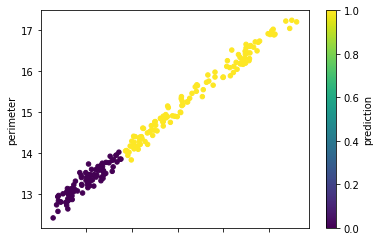

In [97]:
df.plot.scatter(x='area',y='perimeter',c='prediction', cmap='viridis')

<AxesSubplot:xlabel='length_of_kernel', ylabel='width_of_kernel'>

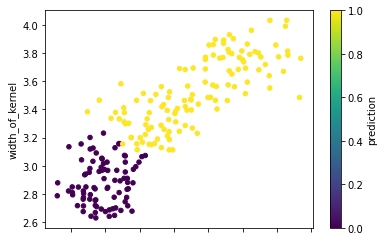

In [98]:
df.plot.scatter(x='length_of_kernel',y='width_of_kernel',c='prediction',cmap='viridis')